# A simple ripple carry adder on the QPU

In this notebook we implement a "simple" reversible binary adder. It is based on

*A new quantum ripple-carry addition circuit*, by 
Cuccaro, Draper, Kutin, and Moulton. See
https://arxiv.org/abs/quant-ph/0410184v1 .

The whole circuit is classical in the sense that we start and end in computational basis states and all gates simply perform classical not, controlled not, or doublely controled not.

In [3]:
import numpy as np
from pyquil.quil import Program
from pyquil.quilbase import Pragma 
from pyquil.gates import *
import pyquil.api as api
from pyquil.api import get_qc, get_benchmarker
from forest_benchmarking.benchmarks.classical_logic_circuits.classical_reversible_logic_primitives import *
from scipy.spatial.distance import hamming
from scipy.special import comb
import time
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
# noiseless QVM
#qc = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
qc = get_qc("9q-generic", as_qvm=True, noisy=True)

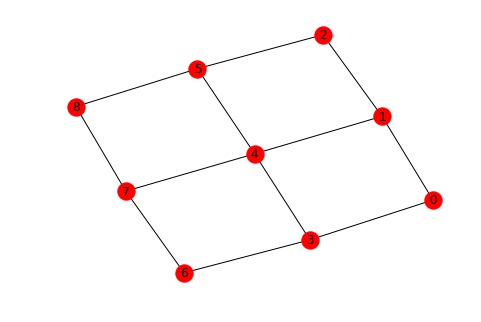

In [5]:
nx.draw(qc.qubit_topology(),with_labels=True)

In [6]:
num_of_qubits = len(qc.qubits())

In [7]:
def average_adder_result_over_input_strings(bin_str, num_of_qubits, CNOTfun = CNOT, CCNOTfun = CCNOT):
    """
    Find hamming weight distribution of errors relative to correct answer averaged over input strings.
    
    The default option is to compute this in the computational (aka Z) basis. By passing in
    CNOTfun and CCNOTfun as CNOT_X_basis and CCNOT_X_basis the computation happens in the X basis.
    
    :param bin_str: a list of lists that contains all binary strings of length 2n, the
    adder adds who strings of length n.
    :param num_of_qubits: int
    :param CNOTfunc: either CNOT or CNOT_X_basis
    :param CCNOTfunc: either CCNOT or CCNOT_X_basis
    :returns wt: hamming weights from QPU or QVM
    """
    
    # loop over all binary strings of length "n"
    for binstr_idx in bin_str:
        # split the binary number into two numbers and store in a tuple
        # These are the binary numbers the user wants to add.
        # They are written from (MSB .... LSB) = (a_n, ..., a_1, a_0)
        num_a = tuple(binstr_idx[0:n])
        num_b = tuple(binstr_idx[n:2*n])

        # convert to string
        string_a = "".join([str(x) for x in num_a])
        string_b = "".join([str(x) for x in num_b])

        # add the numbers
        ans_str= int(string_b,2)+int(string_a,2)

        # convert back to a binary list of the right length
        desired_answer = [int(x) for x in format(ans_str,'0'+str(2*n-(n-1))+'b')]

        # do a check on the numbers
        check_binary_number_length(num_a, num_b, num_of_qubits)

        # create the qubit labels  
        qbit_labels = get_qubit_labels(num_a)

        # state prep. program.  Take the binary numbers and prepare the corresponing state  
        state_prep_prog, register_a, register_b, carry_ancilla, z_ancilla = prepare_binary_numbers(num_a, num_b, qbit_labels, CNOTfun)

        # program to add numbers
        add_binary_numbers = adder(register_a, register_b, carry_ancilla, z_ancilla, CNOTfun, CCNOTfun)
        
        # if computation is happening in the X basis we need a measurement program too
        meas_prog = Program().inst(I(qbit_labels[0]))
        if CNOTfun == CNOT:
            for qbit_idx in qbit_labels:
                # Hadamard to get back to the Z basis before measurement
                meas_prog += H(qbit_idx)
        
        # Run it on the QPU or QVM
        qpustart = time.time()
        print(add_binary_numbers)
        result = qc.run_and_measure(state_prep_prog + add_binary_numbers + meas_prog, trials=num_trials)
        qpuend = time.time()
        print('runtime: ' + str(qpuend - qpustart))
        result = np.vstack(result[q] for q in qbit_labels).T

        #Figure out where the results are stored
        sumk = []
        for result_idx in qbit_labels[1:-1]:
            if result_idx in register_b:
                sumk.insert(0,qbit_labels.index(result_idx))
        #make sure you append the carry bit silly!!
        sumk.insert(0,len(qbit_labels)-1)

        # get the answer   
        answer = []
        for trials_idx in range(num_trials):
            temp =[]
            for ans_idx in sumk:
                temp.append(result[trials_idx][ans_idx])
            answer.append(temp)
            
        # find hamming weight between desired_answer (correct) and QPU / QVM result
        count = 0
        for i in range(len(answer)):
            wt[binstr_idx,i]= (n)*hamming(desired_answer, answer[i])
            if desired_answer == answer[i]:
                count +=1
        # Sloppy accounting for the case where the number of
        # sucesses equals zero
        if count == 0:
            count +=1
        print('Pr(suc) = '+ str(count/num_trials))
    return wt

# Addition in the Z (Computational) basis results

runtime: 1.3064579963684082
Pr(suc) = 0.25
runtime: 0.998553991317749
Pr(suc) = 0.25
runtime: 0.8788619041442871
Pr(suc) = 0.2
runtime: 0.725492000579834
Pr(suc) = 0.2


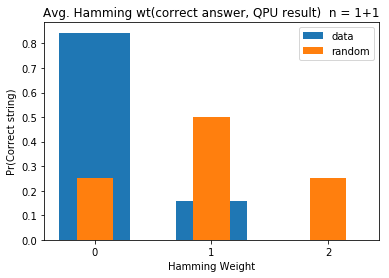

runtime: 1.8589229583740234
Pr(suc) = 0.2
runtime: 1.991332769393921
Pr(suc) = 0.125
runtime: 1.99714994430542
Pr(suc) = 0.2
runtime: 1.8624670505523682
Pr(suc) = 0.05
runtime: 1.8658502101898193
Pr(suc) = 0.075
runtime: 1.815424919128418
Pr(suc) = 0.125
runtime: 1.8163819313049316
Pr(suc) = 0.1
runtime: 1.886094093322754
Pr(suc) = 0.175
runtime: 1.7729802131652832
Pr(suc) = 0.125
runtime: 1.8846769332885742
Pr(suc) = 0.075
runtime: 1.8310699462890625
Pr(suc) = 0.25
runtime: 1.7677240371704102
Pr(suc) = 0.15
runtime: 1.8370187282562256
Pr(suc) = 0.15
runtime: 1.852219820022583
Pr(suc) = 0.1
runtime: 1.8766119480133057
Pr(suc) = 0.1
runtime: 1.805290937423706
Pr(suc) = 0.2


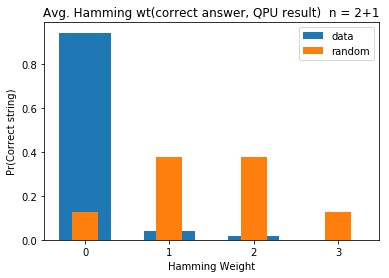

In [8]:
# If equal to 10,000  = 1% error
num_trials = 40 #000

avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for ndx in range(1,3):
    # length of binary string
    n=ndx
    
    bin_str = []
    bin_str = construct_all_possible_input_numbers(n)
    
    # find hamming weight distribution of errors relative to correct
    # answer averaged over all possible input strings
    wt = np.zeros((2**(2*n),num_trials))
    wt = average_adder_result_over_input_strings(bin_str,num_of_qubits)
    histy = construct_bit_flip_error_histogram(wt,n)
    hamming_wt = np.array([comb(n+1,x) for x in list(range(0,n+2))])
    hamming_dist = hamming_wt/sum(hamming_wt)

    # calculate statistics
    exp_average_hamming = np.average(histy,0)/num_trials
    avg_n.append(np.average(histy[0],0)/num_trials)
    med_n.append(np.median(histy[0],0)/num_trials)
    min_n.append(np.min(histy[0],0)/num_trials)
    max_n.append(np.max(histy[0],0)/num_trials)
    rand_n.append(hamming_dist[0])

    # some plotting
    weight_vec = list(np.arange(0,n+2))
    plt.bar(weight_vec,exp_average_hamming,width=0.61,align='center')
    plt.bar(weight_vec,hamming_dist,width=0.31,align='center')
    plt.xticks(weight_vec, list(range(0,n+2)))
    plt.xlabel('Hamming Weight')
    plt.ylabel('Pr(Correct string)' )
    plt.legend(['data','random'])
    plt.title('Avg. Hamming wt(correct answer, QPU result)' '  n = ' + str(n) + '+' +str(1))
    name = 'hamm_n_equal_' + str(n)
    plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()

# Addition in the X basis results

runtime: 0.8560998439788818
Pr(suc) = 0.225
runtime: 0.837130069732666
Pr(suc) = 0.275
runtime: 0.7872509956359863
Pr(suc) = 0.25
runtime: 0.7553541660308838
Pr(suc) = 0.225


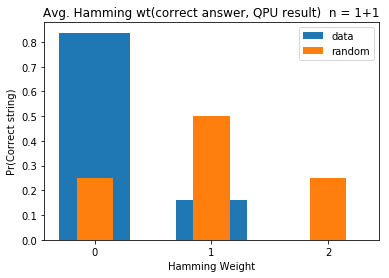

runtime: 1.9475767612457275
Pr(suc) = 0.1
runtime: 2.0232138633728027
Pr(suc) = 0.05
runtime: 2.120298385620117
Pr(suc) = 0.05
runtime: 1.879486083984375
Pr(suc) = 0.075
runtime: 1.9667320251464844
Pr(suc) = 0.125
runtime: 1.945770025253296
Pr(suc) = 0.05
runtime: 1.8539447784423828
Pr(suc) = 0.025
runtime: 1.9483740329742432
Pr(suc) = 0.1
runtime: 1.9713902473449707
Pr(suc) = 0.1
runtime: 1.8854248523712158
Pr(suc) = 0.125
runtime: 1.8954660892486572
Pr(suc) = 0.125
runtime: 1.878230094909668
Pr(suc) = 0.125
runtime: 1.889120101928711
Pr(suc) = 0.1
runtime: 1.886733055114746
Pr(suc) = 0.075
runtime: 1.894124984741211
Pr(suc) = 0.175
runtime: 1.8899500370025635
Pr(suc) = 0.075


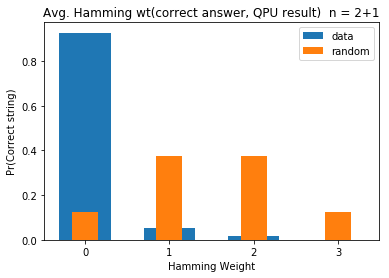

In [11]:
# If equal to 10,000  = 1% error
num_trials = 40 #000

avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for ndx in range(1,3):
    # length of binary string
    n=ndx
    
    bin_str = []
    bin_str = construct_all_possible_input_numbers(n)
    
    # find hamming weight distribution of errors relative to correct
    # answer averaged over all possible input strings
    wt = np.zeros((2**(2*n),num_trials))
    wt = average_adder_result_over_input_strings(bin_str, num_of_qubits, CNOT_X_basis, CCNOT_X_basis)
    histy = construct_bit_flip_error_histogram(wt,n)
    hamming_wt = np.array([comb(n+1,x) for x in list(range(0,n+2))])
    hamming_dist = hamming_wt/sum(hamming_wt)

    # calculate statistics
    exp_average_hamming = np.average(histy,0)/num_trials
    avg_n.append(np.average(histy[0],0)/num_trials)
    med_n.append(np.median(histy[0],0)/num_trials)
    min_n.append(np.min(histy[0],0)/num_trials)
    max_n.append(np.max(histy[0],0)/num_trials)
    rand_n.append(hamming_dist[0])

    # some plotting
    weight_vec = list(np.arange(0,n+2))
    plt.bar(weight_vec,exp_average_hamming,width=0.61,align='center')
    plt.bar(weight_vec,hamming_dist,width=0.31,align='center')
    plt.xticks(weight_vec, list(range(0,n+2)))
    plt.xlabel('Hamming Weight')
    plt.ylabel('Pr(Correct string)' )
    plt.legend(['data','random'])
    plt.title('Avg. Hamming wt(correct answer, QPU result)' '  n = ' + str(n) + '+' +str(1))
    name = 'hamm_n_equal_' + str(n)
    plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()